In [2]:
from Halite import *
from paleopy import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


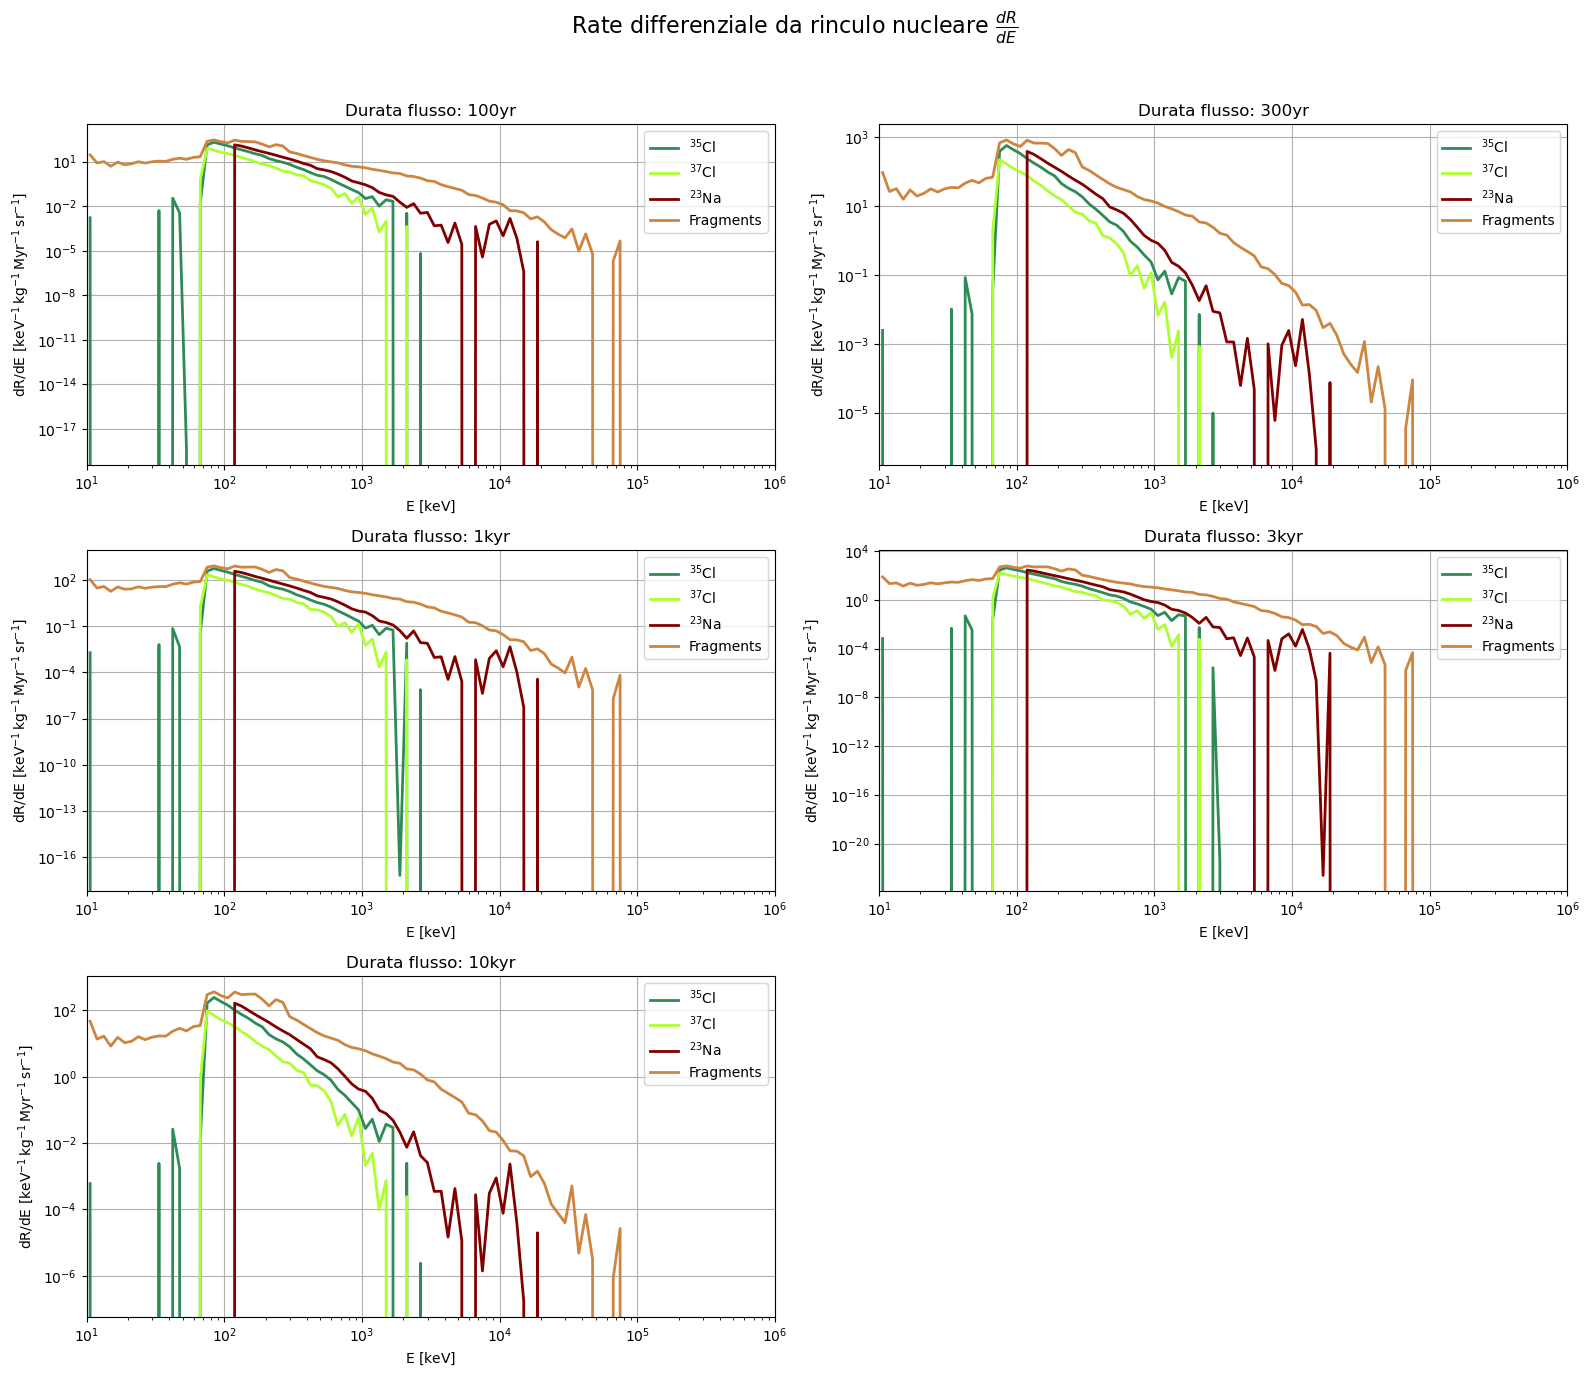

In [21]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 13500 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr", "10kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [1.5e-4, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2]  # Intervallo tra un flusso e l'altro in Myr

# Crea la figura e i subplot 3x2
fig, axs = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dE}}$", fontsize=16)

for i, label in enumerate(label_time_fluxes):
    # Carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    # Crea un array di flussi interpolati
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)  # Energia in GeV e flusso m-2*s-1*sr-1*GeV-1

    # Integra e calcola conteggi
    Num = Integration([flux_func], [time_fluxes[i]], time_exposure)  # Array somma delle energie di tutti i flussi, normalizzato al tempo totale
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)  # Larghezza del bin
    Er_mid = Er[:-1] + Er_width / 2  # Punto medio del bin

    Frag = np.zeros(len(Er_mid))  # Array con tutti i punti medi dei bin di energia
    for k in range(len(Conta[4])):  # Conta[4]=lunghezza di nuclei
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]  # Somma i bin dei vari nuclei

    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')  # Interpolazione
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Seleziona il subplot corrente
    ax = axs[i // 2, i % 2]
    axs[2,1].set_visible(False) #nascondo il subplor che non mi serve

    # Disegna nel subplot corrente
    ax.loglog(Er_mid * 1e3, F35(Er_mid) * 1e-3 / (length * rho), label="$^{35}$Cl", linewidth=2, color='seagreen')
    ax.loglog(Er_mid * 1e3, F37(Er_mid) * 1e-3 / (length * rho), label="$^{37}$Cl", linewidth=2, color='greenyellow')
    ax.loglog(Er_mid * 1e3, F23(Er_mid) * 1e-3 / (length * rho), label="$^{23}$Na", linewidth=2, color='maroon')
    ax.loglog(Er_mid * 1e3, Frag * 1e-3 / Er_width / (length * rho), label='Fragments', linewidth=2, color='peru')

    ax.set_xlabel("E [$\\mathrm{keV}$]")
    ax.set_ylabel("dR/dE [$\\mathrm{keV}^{-1}\\,\\mathrm{kg}^{-1}\\,\\mathrm{Myr}^{-1}\\,\\mathrm{sr}^{-1}$]")
    ax.set_xlim(1e1, 1e6)
    ax.legend()
    ax.grid(True)
    ax.set_title(f"Durata flusso: {label}")

# Aggiusta gli spazi tra i subplot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Lascia spazio per il titolo generale
plt.show()


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

## $\frac{dR}{dx}$ sommando tutti i i-esimi nuclei, pesati, tramite la chain rule


In [23]:
import paleopy as paleopy
from paleopy import *

halite = paleopy.Mineral("Halite")

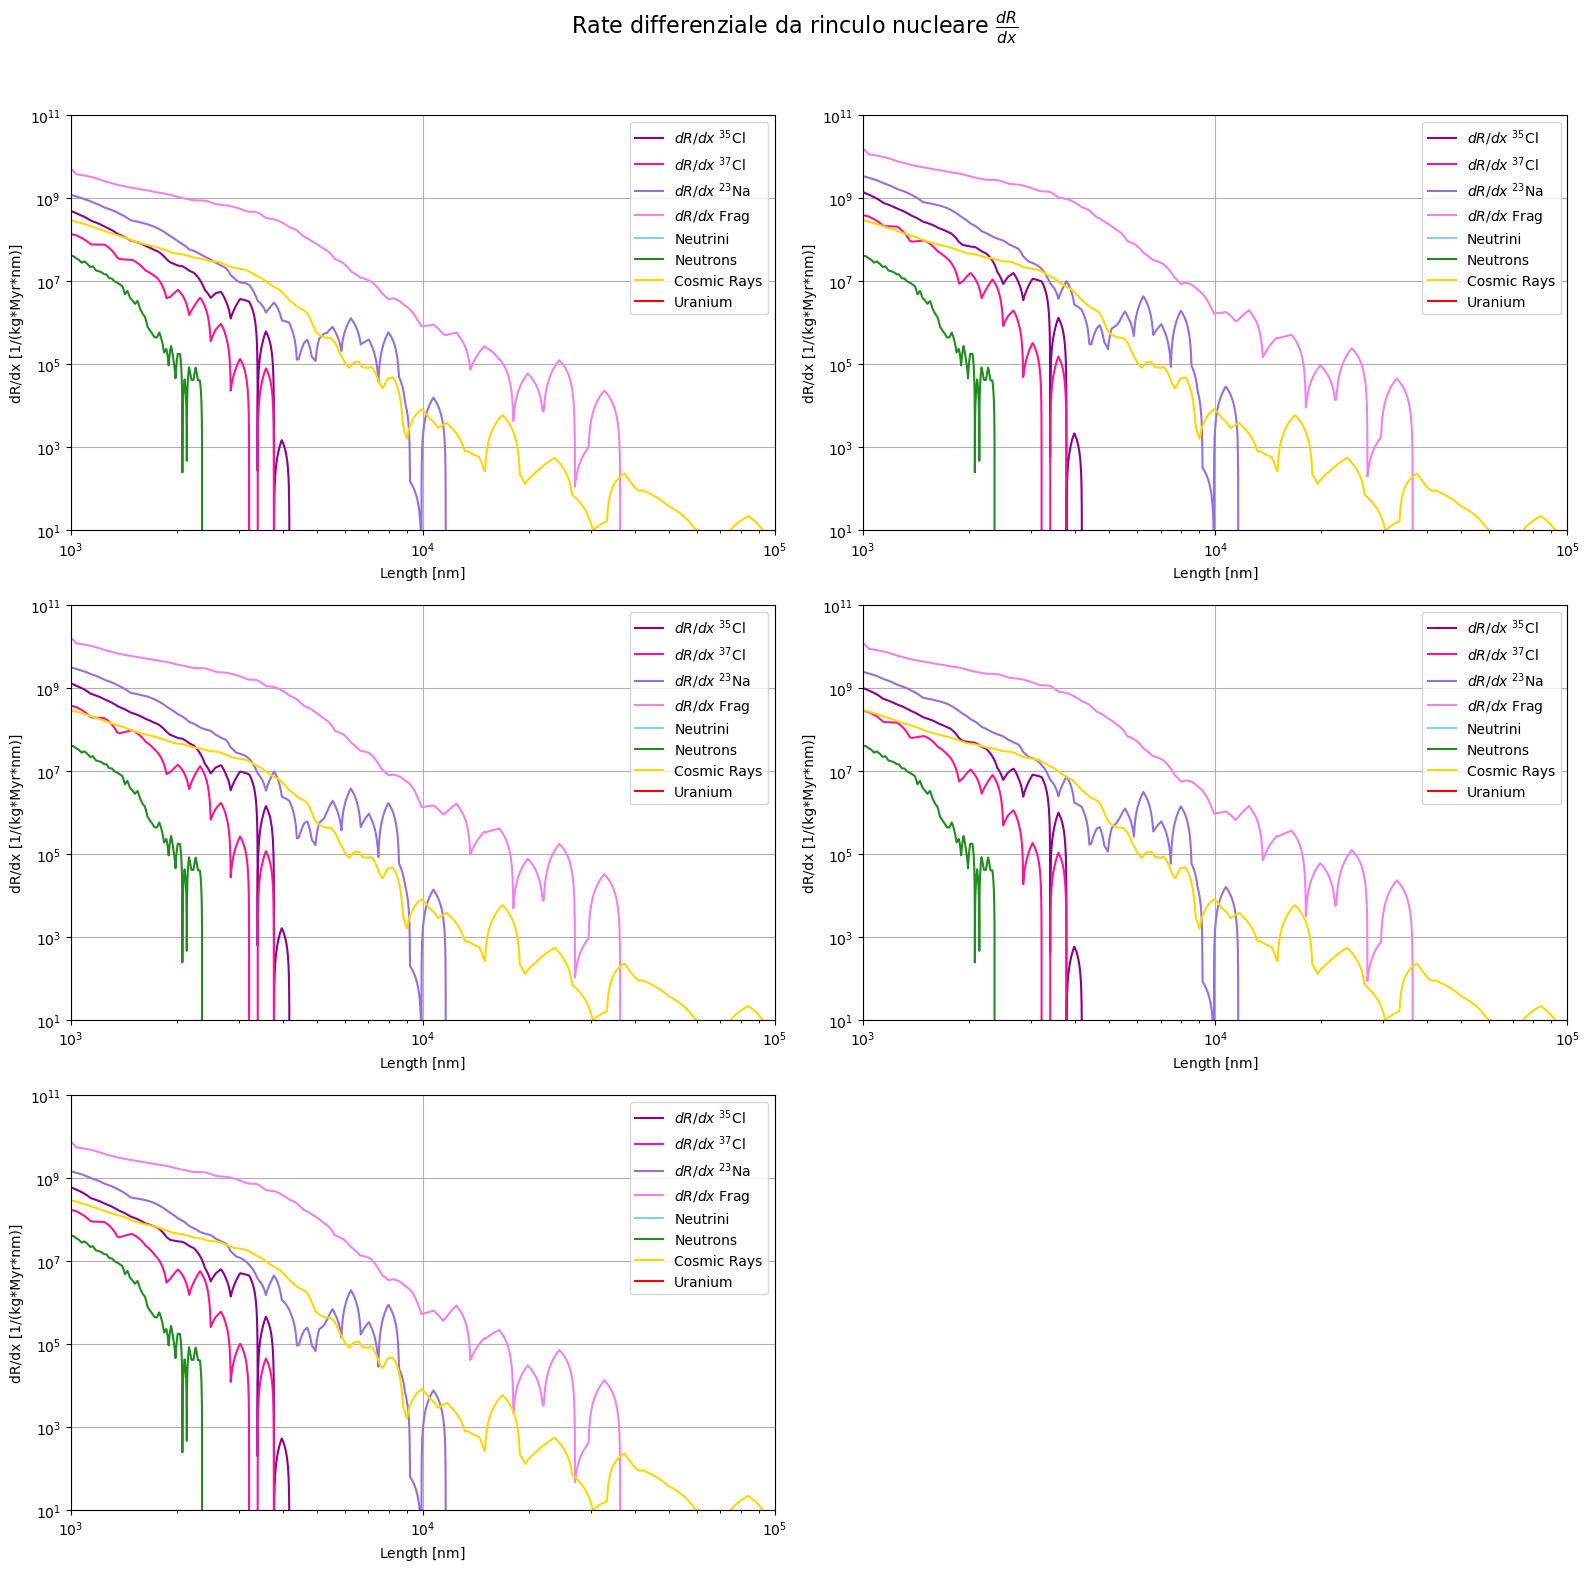

In [30]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 13500 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr", "10kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [1.5e-4, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2]  # Intervallo tra un flusso e l'altro in Myr


# Crea la figura e i subplot 2x2
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle("Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dx}}$", fontsize=16)

for idx, label in enumerate(label_time_fluxes):
    
    # Carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    # Crea un array di flussi interpolati
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)  # Energia in GeV e flusso m^-2*s^-1*sr^-1*GeV^-1

    # Integra e calcola conteggi
    Num = Integration([flux_func], [time_fluxes[idx]], time_exposure)
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)
    Er_mid   = Er[:-1] + Er_width / 2

    # Somma i fragmenti di tutti i nuclei
    Frag = np.zeros(len(Er_mid))
    for k in range(len(Conta[4])):  # Conta[4] = "lunghezza di nuclei" (?) 
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]  # Somma i bin dei vari nuclei

    # Interpola i contributi (F35, F37, F23) e normalizza con factor/Er_width
    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Sceglie il subplot
    ax = axs[idx // 2, idx % 2]
    axs[2,1].set_visible(False) #nascondo il subplor che non mi serve

    # Aggiungo il calcolo di dR/dx (z_bins in nm)
    z_bins = np.linspace(0, 100000, 100000)
    #correzione numero di z_bins
    zz_centre = z_bins[:-1] +  np.diff(z_bins)/2.

    # dR/dE -> dR/dx con la funzione dRdx_modified(...)
    # Divido per (length*rho) se interpretato come conversione tra sezione e massa
    y_values35 = halite.dRdx_modified(z_bins, Er_mid*1e3, F35(Er_mid)*1e-3/(length*rho))
    y_values37 = halite.dRdx_modified(z_bins, Er_mid*1e3, F37(Er_mid)*1e-3/(length*rho))
    y_values23 = halite.dRdx_modified(z_bins, Er_mid*1e3, F23(Er_mid)*1e-3/(length*rho))
    # Somma di tutti i frammenti
    y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid*1e3, Frag*1e-3/Er_width/(length*rho))
    
    # Altri contributi
    y_nu        = halite.dRdx_nu(z_bins)
    y_neutrons  = halite.dRdx_neutrons(z_bins)
    y_cosmicrays = halite.dRdx_muons_new(z_bins, "Resconi")
    
    #adding Uranium tracks
    data_U = np.loadtxt("../Fission/Uranium_counts.txt", comments="#")
    i_index = data_U[:,0]   # 0..(n_bins-2)
    count_U = data_U[:,1]   # lunghezza 199

    U_x_min = 1
    U_x_max = 5
    U_n_bins = 200
    U_length = np.logspace(U_x_min, U_x_max, U_n_bins) 
    length_centers = 0.5*(U_length[:-1] + U_length[1:])
    bin_widths = U_length[1:] - U_length[:-1]

    
    y_U = count_U / bin_widths
    f_U = interp1d(length_centers, y_U, bounds_error=False, fill_value=0.0)
    yU_interp = f_U(zz_centre)

    # Plot
    ax.loglog(zz_centre, y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta')
    ax.loglog(zz_centre, y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink')
    ax.loglog(zz_centre, y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple')
    ax.loglog(zz_centre, y_valuesFrag, label='$dR/dx$ Frag', color='violet')

    # Valuta tu se serve la stessa scala:
    ax.loglog(zz_centre, y_nu, label='Neutrini', color='skyblue')
    ax.loglog(zz_centre, y_neutrons, label='Neutrons', color='forestgreen')
    ax.loglog(zz_centre, y_cosmicrays, label='Cosmic Rays',color='gold')
    ax.loglog(zz_centre, yU_interp, label='Uranium', color='red')


    ax.set_xlabel("Length [$\\mathrm{nm}$]")
    ax.set_ylabel("dR/dx [1/(kg*Myr*nm)]")
    ax.set_xlim(1e3, 1e5)
    ax.set_ylim(1e1, 1e11)
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Difference between tracks with and without the correction of Zircon

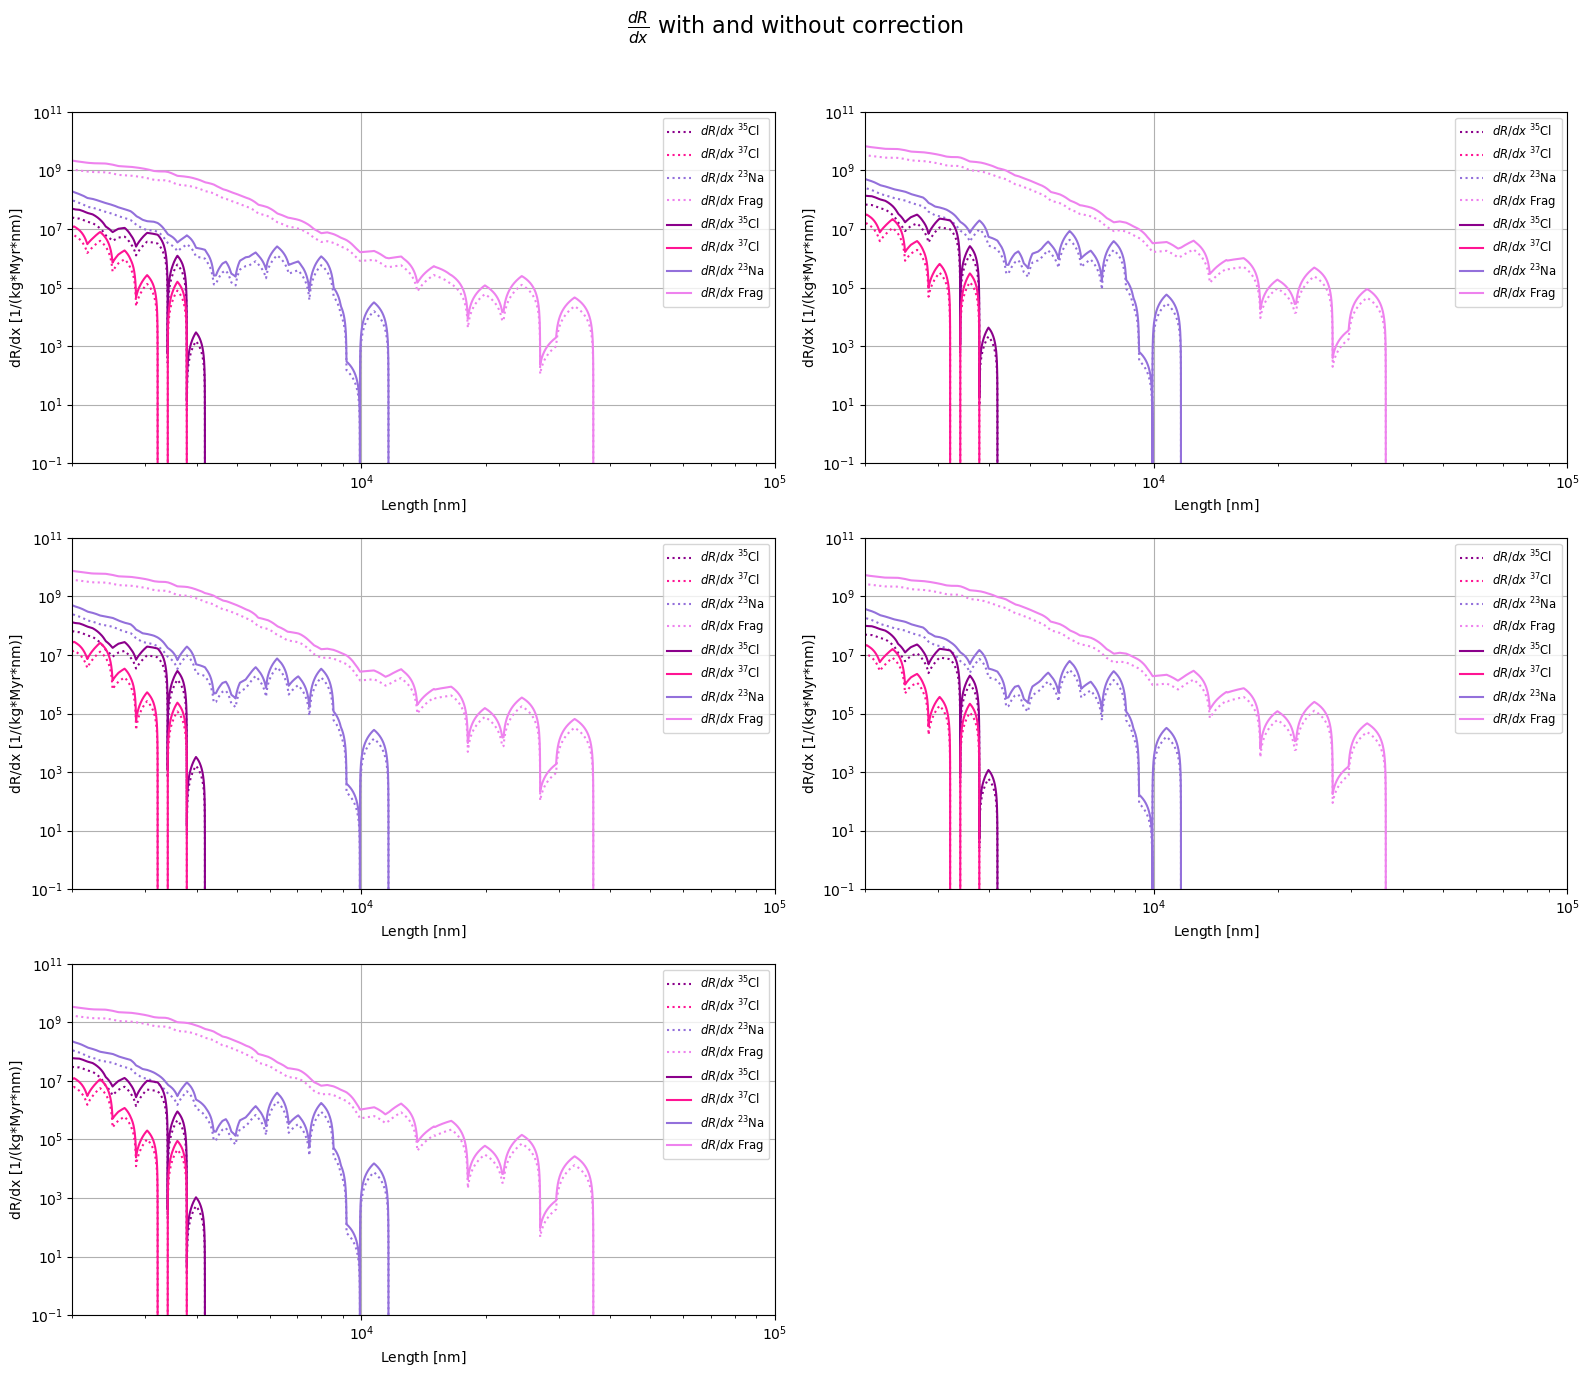

In [31]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 13500 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr", "10kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [1.5e-4, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2]  # Intervallo tra un flusso e l'altro in Myr
ratio=2


# Crea la figura e i subplot 3x2
fig, axs = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("$\\frac{{dR}}{{dx}}$ with and without correction", fontsize=16)

for idx, label in enumerate(label_time_fluxes):
    
    # Carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    # Crea un array di flussi interpolati
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)  # Energia in GeV e flusso m^-2*s^-1*sr^-1*GeV^-1

    # Integra e calcola conteggi
    Num = Integration([flux_func], [time_fluxes[idx]], time_exposure)
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)
    Er_mid   = Er[:-1] + Er_width / 2

    # Somma i fragmenti di tutti i nuclei
    Frag = np.zeros(len(Er_mid))
    for k in range(len(Conta[4])):  # Conta[4] = "lunghezza di nuclei" (?) 
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]  # Somma i bin dei vari nuclei

    # Interpola i contributi (F35, F37, F23) e normalizza con factor/Er_width
    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Sceglie il subplot
    ax = axs[idx // 2, idx % 2]
    axs[2,1].set_visible(False) #nascondo il subplor che non mi serve

    # Aggiungo il calcolo di dR/dx (z_bins in nm)
    z_bins = np.linspace(0, 100000, 100000)
    #correzione z_bins
    zz_centre = z_bins[:-1] +  np.diff(z_bins)/2.


    # Divido per (length*rho) se interpretato come conversione tra sezione e massa
    y_values35 = halite.dRdx_modified(z_bins, Er_mid*1e3, F35(Er_mid)*1e-3/(length*rho))
    y_values37 = halite.dRdx_modified(z_bins, Er_mid*1e3, F37(Er_mid)*1e-3/(length*rho))
    y_values23 = halite.dRdx_modified(z_bins, Er_mid*1e3, F23(Er_mid)*1e-3/(length*rho))
    # Somma di tutti i frammenti
    y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid*1e3, Frag*1e-3/Er_width/(length*rho))
    

    # Plot without corrections
    ax.loglog(zz_centre, y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta', linestyle=":")
    ax.loglog(zz_centre, y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink', linestyle=":")
    ax.loglog(zz_centre, y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple', linestyle=":")
    ax.loglog(zz_centre, y_valuesFrag, label='$dR/dx$ Frag', color='violet', linestyle=":")

    # Plot with corrections
    ax.loglog(zz_centre, ratio*y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta')
    ax.loglog(zz_centre, ratio*y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink')
    ax.loglog(zz_centre, ratio*y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple')
    ax.loglog(zz_centre, ratio*y_valuesFrag, label='$dR/dx$ Frag', color='violet')

    ax.set_xlabel("Length [$\\mathrm{nm}$]")
    ax.set_ylabel("dR/dx [1/(kg*Myr*nm)]")
    ax.set_xlim(2e3, 1e5)
    ax.set_ylim(0.1, 1e11)
    ax.legend(loc="upper right", fontsize="small")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Number of tracks per track length

In [32]:
def integrate_in_bins(x, y, x_bins):
    """
    x: array 1D con i punti su cui è definita la curva (es. zz_centre).
    y: array 1D corrispondente, con dR/dx(x).
    x_bins: bordi dei bin, ad es. np.logspace(3,5,20).

    Restituisce un array con len(x_bins)-1 valori, 
    ognuno corrispondente all'integrale di y in [x_i, x_{i+1}].
    """
    counts = np.zeros(len(x_bins) - 1)
    for i in range(len(counts)):
        # maschera per i punti x dentro il bin
        mask = (x >= x_bins[i]) & (x < x_bins[i+1])
        if np.any(mask):
            # Esempio di integrazione numerica con trapz
            counts[i] = np.trapz(y[mask], x[mask])
    return counts


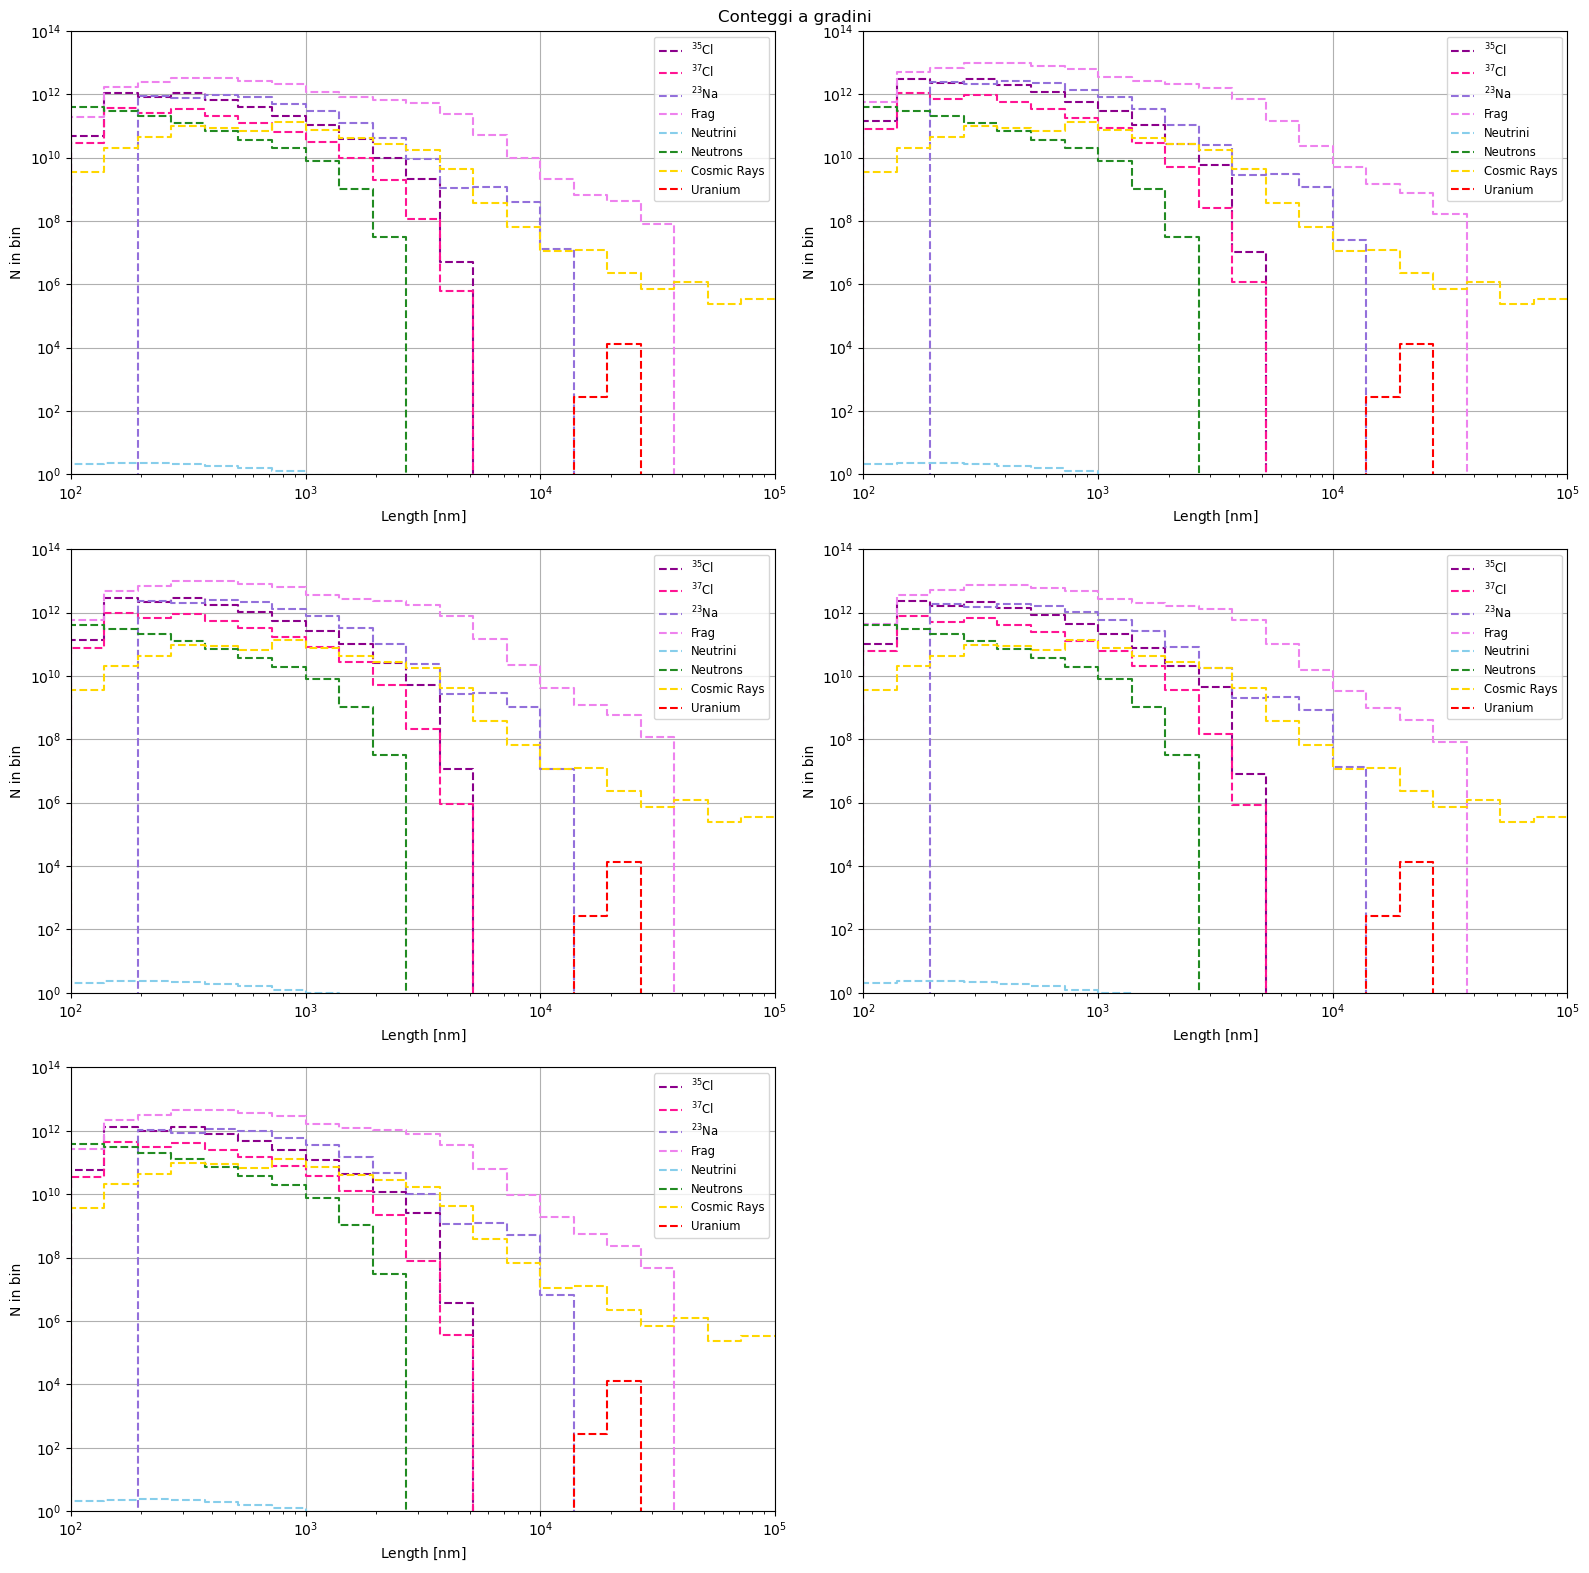

In [44]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV
time_exposure = 13500 * 365 * 24 * 60 * 60  # Tempo di esposizione in secondi 
label_time_fluxes = ["100yr", "300yr", "1kyr", "3kyr", "10kyr"]  # Nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [1.5e-4, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2]  # Intervallo tra un flusso e l'altro in Myr


fig, axs = plt.subplots(3, 2, figsize=(16, 16))
fig.suptitle("Conteggi a gradini")

for idx, label in enumerate(label_time_fluxes):
    # Carica il flusso iniziale e crea interpolatore
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y)

    # Integra e conteggi
    Num = Integration([flux_func], [time_fluxes[idx]], time_exposure)
    Conta = Count(Num, Er)

    Er_width = np.diff(Er)
    Er_mid   = Er[:-1] + Er_width/2

    # Somma i fragmenti vari
    Frag = np.zeros(len(Er_mid))
    for k in range(len(Conta[4])):  # Conta[4] = "lunghezza di nuclei" (?)
        for l in range(len(Er_mid)):
            Frag[l] += Conta[3][k][l]

    # Interpola i contributi
    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Subplot
    ax = axs[idx // 2, idx % 2]
    axs[2,1].set_visible(False) #nascondo il subplor che non mi serve

    # Definiamo i bin su x (lunghezza) e calcoliamo dR/dx
    z_bins = np.linspace(0, 100000, 100000)
    zz_centre = z_bins[:-1] + np.diff(z_bins)/2.

    y_values35 = halite.dRdx_modified(z_bins, Er_mid*1e3, F35(Er_mid)*1e-3/(length*rho))
    y_values37 = halite.dRdx_modified(z_bins, Er_mid*1e3, F37(Er_mid)*1e-3/(length*rho))
    y_values23 = halite.dRdx_modified(z_bins, Er_mid*1e3, F23(Er_mid)*1e-3/(length*rho))

    y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid*1e3, Frag*1e-3/Er_width/(length*rho))
    # Scelta dei bin di lunghezza (in nm), da 1e-2 a 1e5 su scala log:
    i_bins = np.logspace(-2, 5, 50)  # 20 bin => 21 edges

    # Integra y_values nei bin:
    counts_35 = integrate_in_bins(zz_centre, y_values35, i_bins)
    counts_37 = integrate_in_bins(zz_centre, y_values37, i_bins)
    counts_23 = integrate_in_bins(zz_centre, y_values23, i_bins)
    counts_Frag = integrate_in_bins(zz_centre, y_valuesFrag, i_bins)
    counts_nu = integrate_in_bins(zz_centre, y_nu, i_bins)
    counts_neutrons = integrate_in_bins(zz_centre, y_neutrons, i_bins)
    counts_cosmics = integrate_in_bins(zz_centre, y_cosmicrays, i_bins)
    counts_U = integrate_in_bins(zz_centre, yU_interp, i_bins)

    #signal plot
    ax.step(i_bins, np.r_[counts_35, counts_35[-1]], where='post', color='darkmagenta', linestyle='--', label='$^{35}$Cl')
    ax.step(i_bins, np.r_[counts_37, counts_37[-1]], where='post', color='deeppink',   linestyle='--', label='$^{37}$Cl')
    ax.step(i_bins, np.r_[counts_23, counts_23[-1]], where='post', color='mediumpurple', linestyle='--', label='$^{23}$Na')
    ax.step(i_bins, np.r_[counts_Frag, counts_Frag[-1]], where='post', color='violet', linestyle='--', label='Frag')

    #background plot
    ax.step(i_bins, np.r_[counts_nu, counts_nu[-1]], where='post', color='skyblue', linestyle='--', label='Neutrini') #non moltiplico questi background per factor perchè lo sono già le loro y
    ax.step(i_bins, np.r_[counts_neutrons, counts_neutrons[-1]], where='post', color='forestgreen', linestyle='--', label='Neutrons')
    ax.step(i_bins, np.r_[counts_cosmics, counts_cosmics[-1]], where='post', color='gold', linestyle='--', label='Cosmic Rays')
    ax.step(i_bins, np.r_[counts_U, counts_U[-1]], where='post', color='red', linestyle='--', label='Uranium')

    ax.set_xlabel("Length [$\\mathrm{nm}$]")
    ax.set_ylabel("N in bin")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e2, 1e5)
    ax.set_ylim(1, 1e14)
    ax.legend(loc="upper right", fontsize="small")
    ax.grid(True)

plt.tight_layout()
plt.show()


